### <font color="blue">Regression - Stock Market Prediction</font>

Adam Hereth 

## Overview and Learning Objectives

The ML task in this assignment is regression, predicting the `Close` price of Apple stock index [**AAPL**](https://www.google.com/finance/quote/AAPL:NASDAQ). 

In [1]:
# Import all necessary modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from matplotlib.pyplot import figure
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
import xgboost as xgb
from sklearn.metrics import r2_score
from scipy.stats import expon, reciprocal
from sklearn.metrics import accuracy_score


from math import sqrt
%matplotlib inline

import seaborn as seaborn

import warnings
warnings.filterwarnings('ignore')

## Part I - Preprocessing

In [2]:
#!pip install pandas-datareader

In [3]:
import pandas_datareader as pdr

Use live data from ya stock market data is [Yahoo Finance](https://finance.yahoo.com/quote/AAPL?p=AAPL).

In [4]:
df = pdr.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2021-02-26')
df.tail(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-02-12,135.529999,133.690002,134.350006,135.369995,60029300.0,135.369995
2021-02-16,136.009995,132.789993,135.490005,133.190002,80576300.0,133.190002
2021-02-17,132.220001,129.470001,131.250000,130.839996,97918500.0,130.839996
2021-02-18,130.000000,127.410004,129.199997,129.710007,96856700.0,129.710007
2021-02-19,130.710007,128.800003,130.240005,129.869995,87668800.0,129.869995
2021-02-22,129.720001,125.599998,128.009995,126.000000,103916400.0,126.000000
2021-02-23,126.709999,118.389999,123.760002,125.860001,158273000.0,125.860001
2021-02-24,125.559998,122.230003,124.940002,125.349998,111039900.0,125.349998
2021-02-25,126.459999,120.540001,124.680000,120.989998,148199500.0,120.989998


In [5]:
df.reset_index(inplace=True)
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2303.000000,2303.000000,2303.000000,2303.000000,2.303000e+03,2303.000000
mean,40.768029,39.915350,40.345086,40.357003,2.269361e+08,38.642441
std,27.399500,26.611593,27.029006,27.021137,1.790992e+08,27.631704
min,14.271429,13.753571,13.856071,13.947500,4.544800e+07,12.191197
25%,23.092501,22.705357,22.855893,22.805893,1.093298e+08,20.391053
50%,30.525000,30.045000,30.247499,30.295000,1.641152e+08,28.159733
75%,47.552500,46.763750,47.190001,47.182501,2.791866e+08,46.051743
max,145.089996,141.369995,143.600006,143.160004,1.506120e+09,142.946396


In [6]:
corr = df.corr(method='pearson')
corr

,High,Low,Open,Close,Volume,Adj Close
High,1.000000,0.999685,0.999825,0.999780,-0.386792,0.999636
Low,0.999685,1.000000,0.999748,0.999787,-0.395065,0.999657
Open,0.999825,0.999748,1.000000,0.999593,-0.389839,0.999440
Close,0.999780,0.999787,0.999593,1.000000,-0.391277,0.999859
Volume,-0.386792,-0.395065,-0.389839,-0.391277,1.000000,-0.396361
Adj Close,0.999636,0.999657,0.999440,0.999859,-0.396361,1.000000


> You can also visualize the correlations using [seaborn](https://seaborn.pydata.org/installing.html) heatmaps. You should install it if you don't have it.

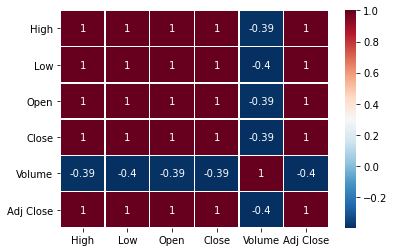

In [7]:
seaborn.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu_r', annot=True, linewidth=0.5)

> Next, drop `Volume` and `Adj Close` as they are not useful for our regression analysis.

In [8]:
# Prepare the dataframe
df = df.drop(columns=['Volume','Adj Close'])
df.head(10)

,Date,High,Low,Open,Close
0,2012-01-03,14.732143,14.607143,14.621429,14.686786
1,2012-01-04,14.810000,14.617143,14.642857,14.765714
2,2012-01-05,14.948214,14.738214,14.819643,14.929643
3,2012-01-06,15.098214,14.972143,14.991786,15.085714
4,2012-01-09,15.276786,15.048214,15.196429,15.061786
5,2012-01-10,15.214286,15.053571,15.211071,15.115714
6,2012-01-11,15.101786,14.975357,15.095714,15.091071
7,2012-01-12,15.103571,14.955357,15.081429,15.049643
8,2012-01-13,15.016071,14.952143,14.989286,14.993214
9,2012-01-17,15.213929,15.105714,15.150000,15.167857


Text(0, 0.5, 'Close Price US($)')

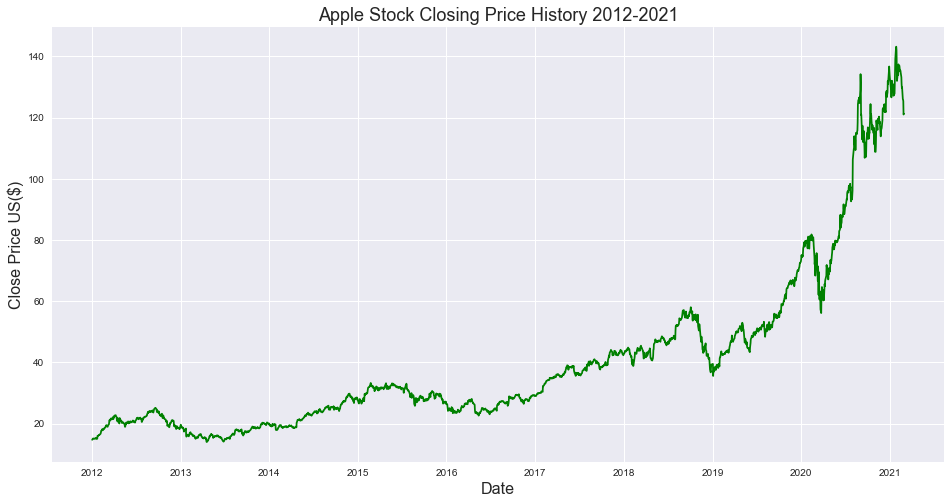

In [9]:
# Generate the following plot.
df = pdr.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2021-02-26')
plt.figure(figsize=(16,8))
plt.style.use('seaborn')
plt.plot(df.index, df['Close'], color = 'g', )
plt.title('Apple Stock Closing Price History 2012-2021', fontsize = 18)
plt.xlabel('Date', fontsize= 16)
plt.ylabel('Close Price US($)', fontsize = 16)

> Next, decompose `Date` to `Year`, `Month`, and `Day`.

In [10]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

> Choose the following columns from `df`

In [11]:
aapl = df.reset_index(drop = True).drop(columns = ['Volume','Adj Close']).filter(items = ('Day','Month','Year','High','Open','Low','Close'))
aapl.tail(10)

,Day,Month,Year,High,Open,Low,Close
2293,12,2,2021,135.529999,134.350006,133.690002,135.369995
2294,16,2,2021,136.009995,135.490005,132.789993,133.190002
2295,17,2,2021,132.220001,131.250000,129.470001,130.839996
2296,18,2,2021,130.000000,129.199997,127.410004,129.710007
2297,19,2,2021,130.710007,130.240005,128.800003,129.869995
2298,22,2,2021,129.720001,128.009995,125.599998,126.000000
2299,23,2,2021,126.709999,123.760002,118.389999,125.860001
2300,24,2,2021,125.559998,124.940002,122.230003,125.349998
2301,25,2,2021,126.459999,124.680000,120.540001,120.989998
2302,26,2,2021,124.849998,122.589996,121.199997,121.260002


> Separating the dependent variables (features) from the independent variable (target column) which is `Close`. So the X should contain all columns in `aapl` except `Close` and y should include `Close` only.

In [12]:
# Separate features from the target
X = aapl.drop(columns = ['Close'])
y = aapl['Close']

In [13]:
print(X.shape)
print(y.shape)

(2303, 6)
(2303,)


> Double-check and make sure that `X` and `y` do NOT have anything in common; otherwise the data is wrong

In [14]:
X

,Day,Month,Year,High,Open,Low
0,3,1,2012,14.732143,14.621429,14.607143
1,4,1,2012,14.810000,14.642857,14.617143
2,5,1,2012,14.948214,14.819643,14.738214
3,6,1,2012,15.098214,14.991786,14.972143
4,9,1,2012,15.276786,15.196429,15.048214
...,...,...,...,...,...,...
2298,22,2,2021,129.720001,128.009995,125.599998
2299,23,2,2021,126.709999,123.760002,118.389999
2300,24,2,2021,125.559998,124.940002,122.230003
2301,25,2,2021,126.459999,124.680000,120.540001


In [15]:
y

0        14.686786
1        14.765714
2        14.929643
3        15.085714
4        15.061786
           ...    
2298    126.000000
2299    125.860001
2300    125.349998
2301    120.989998
2302    121.260002
Name: Close, Length: 2303, dtype: float64

As mentioned in the lectures, the data for supervised learning (both classification and regression) is split into training set and test set. We usually do this by importing [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) module from scikit-learn.
Split the data by a `test_size` ratio of 0.25

In [16]:
# Partition the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1727, 6)
(576, 6)
(1727,)
(576,)


## Part-II Linear Regression with Closed Form Solution (Least Squares)

Now that the data is prepared, training and testing on the regression models can be done.

First, I am going to use the Least Squares method using the normal equation. This allows me to determine the best way of fitting a curve on top of a chart of data points. Since the data is following a scatter plot, it will be easier to interpret, and is associated with regression tasks. 

In [18]:
# Compute theta_best using normal equation
theta_best = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)

In [19]:
theta_best.shape

(6,)

In [20]:
# Make predictions on X_test using theta_best
y_pred_ls = X_test.dot(theta_best)
y_pred_ls

1369     36.463517
1120     24.292622
2084     71.055047
989      29.483051
330      15.350927
           ...    
169      24.021354
2228    118.313268
1932     53.324075
2022     78.548678
858      32.586817
Length: 576, dtype: float64

#### Regression Model Evaluation: MSE, RMSE, MAE

Next is evaluating the regression model.

The three forms of the regression performance measures are MSE, RMSE, and MAE:

$
\text{MSE}(\mathbf{X}, h_{\boldsymbol{\theta}}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{(\boldsymbol{\theta}^T \mathbf{x}^{(i)} - y^{(i)})^2}
$


$
\text{RMSE}(\mathbf{X}, h_{\boldsymbol{\theta}}) = \sqrt{\dfrac{1}{m} \sum\limits_{i=1}^{m}{(\boldsymbol{\theta}^T \mathbf{x}^{(i)} - y^{(i)})^2}}
$

$
\text{MAE}(\mathbf{X}, h_{\boldsymbol{\theta}}) = \frac{1}{m}\sum\limits_{i=1}^{m}\left| \boldsymbol{\theta}^T \mathbf{x}^{(i)} - y^{(i)} \right|
$

where $\boldsymbol{\theta}^T \mathbf{x}^{(i)}$ is your prediction versus $y^{(i)}$ target values, and $m$ is number of instances.

In [21]:
def mse(y_true, y_pred):
    return np.sum(np.square(np.subtract(y_pred, y_true)))/576

In [22]:
def rmse(y_true, y_pred):
    return np.sqrt(np.sum(np.square(np.subtract(y_pred, y_true)))/576)

In [23]:
def mae(y_true, y_pred):
    return np.sum(np.absolute(np.subtract(y_pred, y_true)))/576

> Now compute the `mse`, `rmse`, and `mae` for the Least Squares regression model. They all should be small numbers less than 0.5. 

In [24]:
mse_ls = mse(y_test, y_pred_ls)
rmse_ls = rmse(y_test, y_pred_ls)
mae_ls = mae(y_test, y_pred_ls)
print('LS MSE', mse_ls)
print('LS RMSE', rmse_ls)
print('LS MAE', mae_ls)

LS MSE 0.1680755554214467
LS RMSE 0.4099701884545347
LS MAE 0.1924327616771655


In [25]:
print('LS MSE', "{:.25f}".format(mse_ls))
print('LS RMSE', "{:.25f}".format(rmse_ls))
print('LS MAE',"{:.25f}".format(mae_ls))

LS MSE 0.1680755554214466984674914
LS RMSE 0.4099701884545347008170779
LS MAE 0.1924327616771654980709627


> Next, you should check your implemented methods `mae` and `mse` by comparing your scores with [scikit-learn methods](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error). They should match precisely.

In [26]:
# Compute mae and mse of LS model by sklearn methods
sklearn_mae_ls = mean_absolute_error(y_test, y_pred_ls)
sklearn_mse_ls = mean_squared_error(y_test, y_pred_ls)
print('MAE',"{:.25f}".format(sklearn_mae_ls))
print('MSE',"{:.25f}".format(sklearn_mse_ls))

MAE 0.1924327616771654980709627
MSE 0.1680755554214466984674914


In [27]:
if sklearn_mae_ls == mae_ls:
    print('MAE is correct!')
else:
    print('MAE is wrong!')
    
if sklearn_mse_ls == mse_ls:
    print('MSE is correct!')
else:
    print('MSE is wrong!')  

MAE is correct!
MSE is correct!


> The plot shows that `Actual` target values and `Prediction` values match very highly.

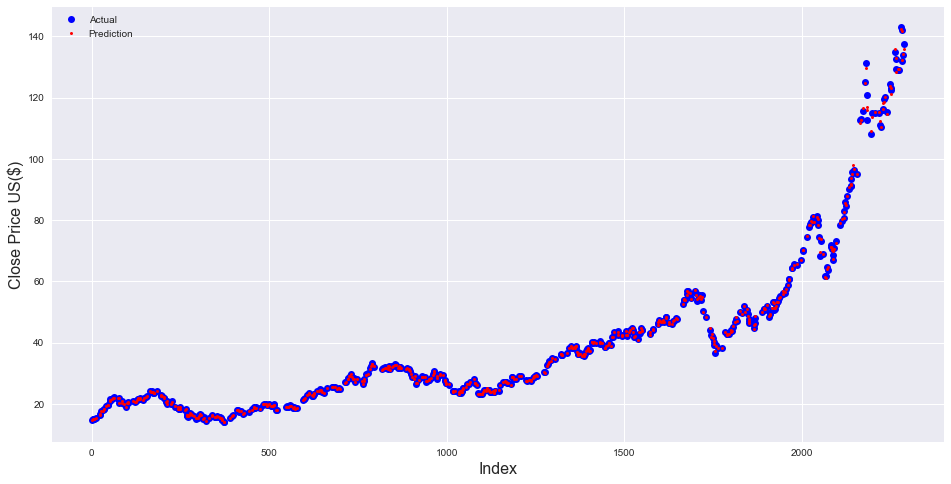

In [28]:
# Generate the following plot.
plt.rcParams["figure.figsize"]=(16,8)
plt.plot(y_test, 'o', label='Actual', color='blue')
plt.plot(y_pred_ls, 'o', label='Prediction', color='red', markersize='3')
plt.xlabel('Index', fontsize = 16)
plt.ylabel('Close Price US($)', fontsize = 16)
plt.legend(frameon=False)

### Part-II Questions

- Q1 [5 points] Why `theta_best.shape` shape is (6,)? You should explain completely.

- Answer of Q1: The best values from each of the 6 columns are used, hence why its shape is (6,). However, theta is only gonna be computed for each column, not every cell. 


- Q2 [5 point] Do some research and find out when/why mae may be favored against mse and vice-versa. In other words, in what situations mae is a better indication of model performance and in what situations mse? Explain your findings completely.

- Answer of Q2: 
- MAE: Few to no outliers in data or when ignoring the data while fitting the model. Fit data based on median.
- MSE: When there are a large number of outliers in the data and want to accommodate for it during the fitting of the model. Fit data based on average


## Part-III  Linear Regression, SVM and XGBoost

In Part-III, you are going to use [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html), [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) and [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) to build regression models.

In [29]:
# Build a LinearRegression model and train it on (X_train, y_train)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [30]:
# Test lin_reg on X_test
y_pred_lin_reg = lin_reg.predict(X_test)

In [31]:
# Compute rmse for lin_reg using your own rmse function
rmse_lin_reg = rmse(y_test, y_pred_lin_reg)
print('Linear Regression RMSE', rmse_lin_reg)

Linear Regression RMSE 0.4099373524332785


Text(0, 0.5, 'Actual')

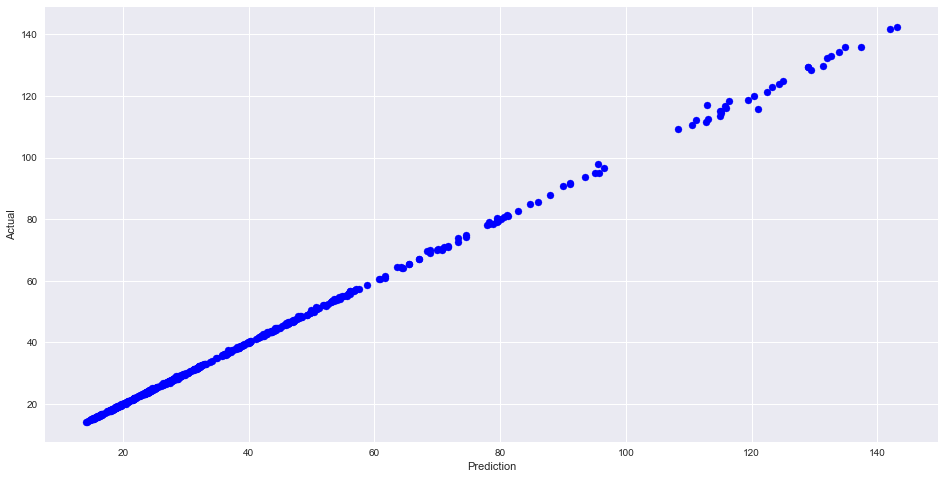

In [32]:
# Plot Q3
plt.scatter(y_test, y_pred_lin_reg, color = 'b') 
plt.xlabel('Prediction')
plt.ylabel('Actual')

> Next build a SVM regression model. Remember that SVM can be used for both classification and regression.

In [33]:
# Build a SVR (SVM Regression) model and train it on (X_train, y_train), kernel should be 'linear'
svm_reg = svm.SVR(kernel = 'linear')
svm_reg.fit(X_train, y_train)

SVR(kernel='linear')

In [34]:
# Test svm_reg
y_pred_svm = svm_reg.predict(X_test)

In [35]:
# Compute rmse for svm_reg
rmse_svm = rmse(y_test, y_pred_svm)
print('SVM RMSE', rmse_svm)

SVM RMSE 0.6171019731630152


> Next, you should create an [XGBoost Regression](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) model. You can simply `import xgboost` and build a `XGBRegressor()` model.

In [36]:
# Build a xgb regression model and train it on (X_train, y_train)
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
# Test xgb_reg
y_pred_xgb = xgb_reg.predict(X_test)

In [38]:
# Compute rmse for xgb_reg
rmse_xgb = rmse(y_test, y_pred_xgb)
print('XGB RMSE', rmse_xgb)

XGB RMSE 0.5955133539307399


fine-tune hyperparameters of XGBoost! 

> If a model has a lot of hyperparameters, it is not an easy task to fine-tune them, and as you experienced, `GridSearchCV` takes a lot of time, so this time you're going to use a different search strategy [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) which is much faster and more efficient than `GridSearchCV` (which is more suitable when you have fewer number of combinations).

In [44]:
xgb_reg = xgb.XGBRegressor(objective='reg:squaredlogerror',
                          booster='gblinear')

param_distribs = { "n_estimators":[200],
                  'booster': ['gblinear'],
                 }
randomized_search = RandomizedSearchCV(xgb_reg, param_distribs, n_iter=10, cv=10)
best_xgb_reg = randomized_search.fit(X_train, y_train)
print('Randomized search for hyperparameter tuning of XGBoost Regressor')
print('Best Parameters: ' + str(best_xgb_reg.best_params_))

Randomized search for hyperparameter tuning of XGBoost Regressor
Best Parameters: {'n_estimators': 200, 'booster': 'gblinear'}


In [46]:
# Train and test best_xgb, and compute rmse with your own rmse function
best_xgb = best_xgb_reg.best_estimator_
best_xgb.fit(X_train, y_train)
y_pred_best_xgb = best_xgb.predict(X_test)
rmse_best_xgb = rmse(y_test, y_pred_best_xgb)
print('Best XGB RMSE', rmse_best_xgb)

Best XGB RMSE 0.48238127739371417


> Last step is calculating another regression performance measure $R^2$ [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination). You can use sklearn [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) method. All $R^2$ scores of your regression models should be close to 1. 

In [41]:
r2_ls = r2_score(y_test, y_pred_ls)
r2_lin_reg = r2_score(y_test, y_pred_lin_reg)
r2_svm = r2_score(y_test, y_pred_svm)
r2_xgb = r2_score(y_test, y_pred_best_xgb)
print('Least Squares R2: ', r2_lin_reg)
print('Linear Regression R2: ', r2_lin_reg)
print('SVM R2: ', r2_svm)
print('XGBoost R2: ', r2_xgb)

Least Squares R2:  0.9997543047717475
Linear Regression R2:  0.9997543047717475
SVM R2:  0.9994432302797848
XGBoost R2:  0.999628898781633


### Part-III Question

- Q3 [5 points] What does `Plot Q3` the Actual-Predicted plot of `lin_reg` model imply? Explain completely. You should justify your answer mathematically, otherwise your answer gets zero.
- Answer of Q3: This model implies a high R2 score which it has since all the points would be close to this diagonal line which follows y=mx+b where m is close to 1. This function follows the linear regression form of y^ = b0 + b1. y^ is predicted value of y for a given value of x. b0 is the y intercept, and b1 is the slope. This means that the residual (r = y_test - y_pred_ls) which is difference between the actual value of y and the predicted value is also small meaning that the data is modeled accurately.